In [36]:
import os 
import pandas as pd 
import numpy as np 
import re
import tqdm 
import matplotlib.pyplot as plt
import pickle

import nltk
from nltk import ngrams
import seaborn as sns

In [37]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from collections import Counter
import sentencepiece as spm

In [38]:
print(pd.__version__)

1.3.3


In [39]:
directory = os.getenv('HOME') + '/aiffel/aiffelthon'

In [40]:
df_train = pd.read_csv(directory + '/train_data_0324.csv')
df_test = pd.read_csv(directory + '/test_data_0324.csv')
# df_test['weight'] = df_test['tok_cat'].apply(lambda x : 14 - x)
# df_test = df_test.loc[df_test['tok_cat'] < 6].sample(n=250, weights = 'weight' ,random_state=6) # validation 시간이 너무 오래 걸림, 250개만 사용

### import Tokenizer

In [41]:
data_path = os.getenv('HOME') +'/PocLab/Preprocessing'

spm_8000 = spm.SentencePieceProcessor()
spm_8000.Load(data_path + '/vocab_8000/spm_dec_spm8009.model')

msp_8000 = spm.SentencePieceProcessor()
msp_8000.Load(data_path + '/vocab_8000/spm_dec_msp8009.model')

custom_msp_8000 =  spm.SentencePieceProcessor()
custom_msp_8000.Load(data_path + '/vocab_8000/spm_dec_cmsp8009.model')



True

In [42]:
data_path = os.getenv('HOME') +'/PocLab/Preprocessing'

spm_16000 = spm.SentencePieceProcessor()
spm_16000.Load(data_path + '/vocab_16000/spm_dec_spm16000.model')

msp_16000 = spm.SentencePieceProcessor()
msp_16000.Load(data_path + '/vocab_16000/spm_dec_msp16000.model')

custom_msp_16000 =  spm.SentencePieceProcessor()
custom_msp_16000.Load(data_path + '/vocab_16000/spm_dec_cmsp16000.model')

True

In [43]:
# 토크나이저 dict 만들기

tokenizers_8000 = {'spm' : spm_8000, 'msp' : msp_8000, 'custom_msp' : custom_msp_8000}
tokenizers_16000 = {'spm' : spm_16000, 'msp' : msp_16000, 'custom_msp' : custom_msp_16000}

## unk count
- OOV 개수 확인

### 8000

In [44]:
tok_spm= []
tok_msp= []
tok_coustom = []
split_token = set()
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    split_token |= set(i.split())
    tok_spm.extend(spm_8000.encode(i))
    tok_msp.extend(msp_8000.encode(i))
    tok_coustom.extend(custom_msp_8000.encode(i))

100%|██████████| 948219/948219 [00:53<00:00, 17643.25it/s]


In [46]:
print('split unk cnt : ', 8000 -  len(split_token)*-1)
print('spm unk cnt : ', tok_spm.count(spm_8000.unk_id()))
print('msp unk cnt : ', tok_msp.count(msp_8000.unk_id()))
print('custom_msp unk cnt : ', tok_coustom.count(custom_msp_8000.unk_id()))

split unk cnt :  750827
spm unk cnt :  12226
msp unk cnt :  15055
custom_msp unk cnt :  14715


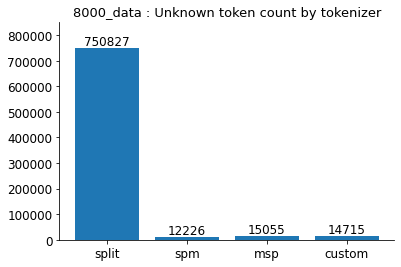

In [47]:
fig, ax = plt.subplots()
bar = ax.bar(x=['split','spm','msp','custom'], height = [750827,tok_spm.count(spm_8000.unk_id()),tok_msp.count(msp_8000.unk_id()),tok_coustom.count(custom_msp_8000.unk_id())])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('8000_data : Unknown token count by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,850000)
plt.show()

### 16000


In [48]:
split_token = set()
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    split_token |= set(i.split())

100%|██████████| 948219/948219 [00:01<00:00, 481877.34it/s]


In [49]:
tok_spm= []
tok_msp= []
tok_coustom = []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    tok_spm.extend(spm_16000.encode(i))
    tok_msp.extend(msp_16000.encode(i))
    tok_coustom.extend(custom_msp_16000.encode(i))

100%|██████████| 948219/948219 [00:43<00:00, 21903.15it/s]


In [50]:
print('split unk cnt : ', 16000 -  len(split_token)*-1)
print('spm unk cnt : ', tok_spm.count(spm_16000.unk_id()))
print('msp unk cnt : ', tok_msp.count(msp_16000.unk_id()))
print('custom_msp unk cnt : ', tok_coustom.count(custom_msp_16000.unk_id()))

split unk cnt :  758827
spm unk cnt :  12226
msp unk cnt :  15055
custom_msp unk cnt :  14715


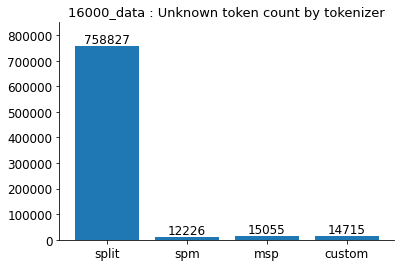

In [51]:
fig, ax = plt.subplots()
bar = ax.bar(x=['split','spm','msp','custom'], height = [758827,tok_spm.count(spm_16000.unk_id()),tok_msp.count(msp_16000.unk_id()),tok_coustom.count(custom_msp_16000.unk_id())])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('16000_data : Unknown token count by tokenizer',fontsize=13) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,850000)
plt.show()

## 요약 
- 8000data oov 개수 
    - msp, custom msp 동일 ( 각 15055 , 14715 ) 
    - split 750827 > 758827 로 증가 
    - spm 12226 > 14715 증가 

### subword fertility
- 토큰화된 단어마다 생성되는 부분단어의 평균 개수

In [52]:
# 8000_data

tok_spm= []
tok_msp= []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    #split by empty space
    tok_spm_len_split = len(i.split())
    
    #split by tokenzier
    tok_spm_len = len(spm_8000.encode(i))
    tok_msp_len = len(msp_8000.encode(i))
    tok_custom_len = len(custom_msp_8000.encode(i))
    
    # find percentage of subword split
    tok_spm.append(tok_spm_len / tok_spm_len_split )
    tok_msp.append(tok_msp_len / tok_spm_len_split)
    tok_custom.append(tok_custom_len / tok_spm_len_split)    

100%|██████████| 948219/948219 [00:49<00:00, 19346.41it/s]


In [53]:
print('spm subword fertility :',sum(tok_spm)/len(tok_spm))
print('msp subword fertility :',sum(tok_msp)/len(tok_msp))
print('custom_msp subword fertility :',sum(tok_custom)/len(tok_custom))

spm subword fertility : 1.7330845280521454
msp subword fertility : 2.0786015144762375
custom_msp subword fertility : 1.9454232228041808


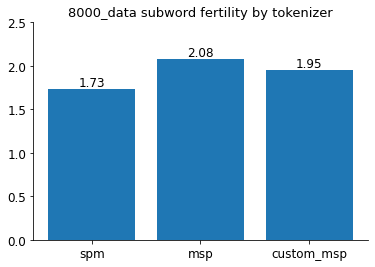

In [54]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/len(tok_spm),2),round(sum(tok_msp)/len(tok_msp),2),round(sum(tok_custom)/len(tok_custom),2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('8000_data subword fertility by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,2.5)
plt.show()

In [55]:
# 16000_data

tok_spm= []
tok_msp= []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    #split by empty space
    tok_spm_len_split = len(i.split())
    
    #split by tokenzier
    tok_spm_len = len(spm_16000.encode(i))
    tok_msp_len = len(msp_16000.encode(i))
    tok_custom_len = len(custom_msp_16000.encode(i))
    
    # find percentage of subword split
    tok_spm.append(tok_spm_len / tok_spm_len_split )
    tok_msp.append(tok_msp_len / tok_spm_len_split)
    tok_custom.append(tok_custom_len / tok_spm_len_split)    

100%|██████████| 948219/948219 [00:44<00:00, 21444.73it/s]


In [56]:
print('spm subword fertility :',sum(tok_spm)/len(tok_spm))
print('msp subword fertility :',sum(tok_msp)/len(tok_msp))
print('custom_msp subword fertility :',sum(tok_custom)/len(tok_custom))

spm subword fertility : 1.5853022400742198
msp subword fertility : 1.9611424670843276
custom_msp subword fertility : 1.784230129181664


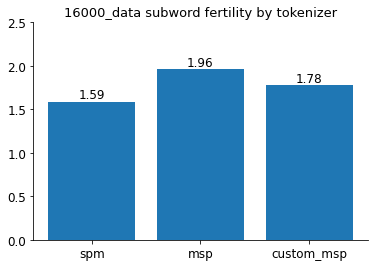

In [57]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/len(tok_spm),2),round(sum(tok_msp)/len(tok_msp),2),round(sum(tok_custom)/len(tok_custom),2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('16000_data subword fertility by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,2.5)
plt.show()

## 요약 
- 8000 > 16000
    - spm만 0.05% 소폭 상승 
    - msp , custom_msp는 감소 

### proportion of continued words
- 말뭉치에서 적어도 두 개의 부분 토큰으로 분할된 토큰화된 단어의 비율 

In [58]:
# 8000_data

tok_spm= []
tok_msp= []
tok_split = []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    total_cnt = 0
    spm_temp = 0
    msp_temp = 0
    custom_temp = 0    
    for k in i.split() :
        if k == ' ' or k ==  '\u200b' or k =='\x9f':
            continue
        total_cnt += 1
        word_spm = spm_8000.encode_as_pieces(k)
        word_msp = msp_8000.encode_as_pieces(k)
        word_custom = custom_msp_8000.encode_as_pieces(k)        
        
        if word_spm[0] == '▁' :
            word_spm.remove('▁')
            
        if word_msp[0] == '▁' :
            word_msp.remove('▁')
            
        if word_custom[0] == '▁' :
            word_custom.remove('▁')
            
        if len(word_spm) > 1 : spm_temp+=1
        if len(word_msp) > 1 : msp_temp+=1
        if len(word_custom) > 1 : custom_temp+=1            
                        
    tok_spm.append(spm_temp)
    tok_msp.append(msp_temp)
    tok_split.append(total_cnt)
    tok_custom.append(custom_temp)    

100%|██████████| 948219/948219 [01:07<00:00, 14056.04it/s]


In [59]:
print('spm proportion of continued words :',sum(tok_spm)/sum(tok_split) * 100)
print('msp proportion of continued words :',sum(tok_msp)/sum(tok_split) * 100)
print('custom_msp proportion of continued words :',sum(tok_custom)/sum(tok_split) * 100)

spm proportion of continued words : 41.42488511139195
msp proportion of continued words : 58.19201897129543
custom_msp proportion of continued words : 53.84054996010769


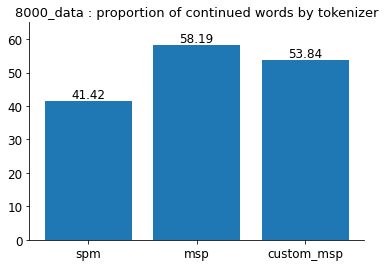

In [60]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/sum(tok_split) * 100,2),round(sum(tok_msp)/sum(tok_split) * 100,2),round(sum(tok_custom)/sum(tok_split) * 100,2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('8000_data : proportion of continued words by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,65)
plt.show()

In [61]:
# 16000_data

tok_spm= []
tok_msp= []
tok_split = []
tok_custom= []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    total_cnt = 0
    spm_temp = 0
    msp_temp = 0
    custom_temp = 0    
    for k in i.split() :
        if k == ' ' or k ==  '\u200b' or k =='\x9f':
            continue
        total_cnt += 1
        word_spm = spm_16000.encode_as_pieces(k)
        word_msp = msp_16000.encode_as_pieces(k)
        word_custom = custom_msp_16000.encode_as_pieces(k)        
        
        if word_spm[0] == '▁' :
            word_spm.remove('▁')
            
        if word_msp[0] == '▁' :
            word_msp.remove('▁')
            
        if word_custom[0] == '▁' :
            word_custom.remove('▁')
            
        if len(word_spm) > 1 : spm_temp+=1
        if len(word_msp) > 1 : msp_temp+=1
        if len(word_custom) > 1 : custom_temp+=1            
                        
    tok_spm.append(spm_temp)
    tok_msp.append(msp_temp)
    tok_split.append(total_cnt)
    tok_custom.append(custom_temp)    

100%|██████████| 948219/948219 [01:03<00:00, 15048.89it/s]


In [62]:
print('spm proportion of continued words :',sum(tok_spm)/sum(tok_split) * 100)
print('msp proportion of continued words :',sum(tok_msp)/sum(tok_split) * 100)
print('custom_msp proportion of continued words :',sum(tok_custom)/sum(tok_split) * 100)

spm proportion of continued words : 33.816071960358265
msp proportion of continued words : 55.49070088287387
custom_msp proportion of continued words : 49.00529938547085


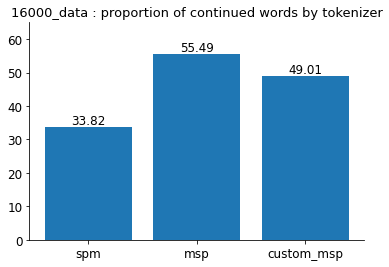

In [63]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','custom_msp'], height = [round(sum(tok_spm)/sum(tok_split) * 100,2),round(sum(tok_msp)/sum(tok_split) * 100,2),round(sum(tok_custom)/sum(tok_split) * 100,2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('16000_data : proportion of continued words by tokenizer', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,65)
plt.show()

### proportion of continued words 요약
- 8000 > 16000
    - spm , custom_msp는 8000과 16000 비율 동일하게 증가  
    - msp 52.48 > 55.49 증가 